In [36]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
__File name__:          IGTLab_RetoFurrer_2019.py
__Author__:             Reto Furrer
__Date created__:       02.09.2019
__Date last modified__: 06.09.2019
__Python Version__:     3.6
__Project__:            IGT-Lab 2019 (02.09.2019-13.09.2019)
__Description__:        This file contains the methods to measure the wall thickness of 
                        polymer tubes in microCT images. 
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import glob

from matplotlib.patches import Arc
from skimage import data, feature, color, filters
from skimage.color import rgb2gray
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from scipy import signal

In [37]:
## General settings
# Appearance of the image
tube_padding = 40

# Appearance of the segmentation
border_col = "red"
border_wid = 2

# Data set
data_set = "X" # "Y"

In [38]:
## Load image data set into list
# Read all images in the folder into images
#images = sorted(glob.glob('img/X/rec/*.png'))

# Read the original image
raw_image = plt.imread('img/X/rec/trial1_rec0136.png')
image = np.asarray(raw_image) # Convert image into array
#plt.imshow(image)

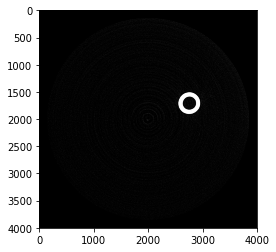

In [39]:
## Preprocessing, i.e. filtering of the image
# Apply gaussian filter to the gray image to reduce salt&pepper noise
img_filtered = ndimage.gaussian_filter(image, sigma=5.5)
#img_filtered = ndimage.median_filter(img_filtered, 3)
#img_filtered = signal.cspline2d(image,10)

# Convert image into gray, only to be sure it is gray in case a rgb image is loaded 
img_gray = color.rgb2gray(img_filtered)
plt.imshow(img_gray, cmap='gray', interpolation='nearest')
plt.savefig('img_filtered_gray.pdf')

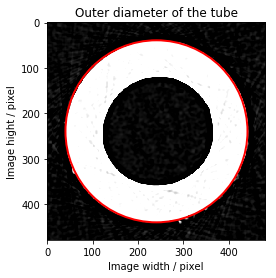

In [40]:
# Apply Canny edge detector to the gray image
img_canny = feature.canny(img_gray, sigma=5.5)

# compute offsets of fullsize image to region of interest 
edge_indices = np.where(img_canny)
position_y_min = min(edge_indices[0])
position_y_max = max(edge_indices[0])
position_x_min = min(edge_indices[1])
position_x_max = max(edge_indices[1])

# Calculating outer diameter based on canny edges
d_outer_x = position_x_max - position_x_min
d_outer_y = position_y_max - position_y_min

#Calculate center point
center = [(position_x_max - position_x_min)/2,(position_y_max - position_y_min)/2]

# copy reduced image       
reduced_img = image[position_y_min-tube_padding:position_y_max+tube_padding, position_x_min-tube_padding:position_x_max+tube_padding]

# Create subplot to print reduced image and the marker for the outer diameter
fig, ax = plt.subplots()
circle = plt.Circle((center[0]+tube_padding,center[1]+tube_padding), d_outer_x/2, color=border_col, fill=False, linewidth=border_wid)
ax.imshow(reduced_img, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.title('Outer diameter of the tube')
plt.xlabel('Image width / pixel')
plt.ylabel('Image hight / pixel')
plt.show() 
fig.savefig('img_outerdiameter.pdf')

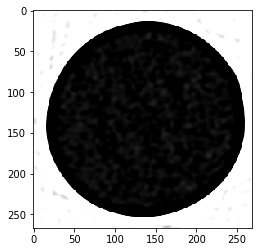

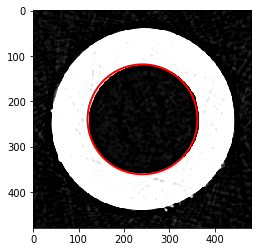

In [41]:
## Find inner diameter of the tube section
# Create offset based on outer diameter of the tube
offset = (np.mean([d_outer_x,d_outer_y])/6)
offset = offset.astype(int) # Convert offset into integer value

# Create new image with an offset of 10% from the outer diameter of the tube
img_offset = image[position_y_min+offset:position_y_max-offset, position_x_min+offset:position_x_max-offset]
plt.imshow(img_offset)
img_offset = color.rgb2gray(np.asarray(img_offset)) # Convert image into array

# Apply Canny edge detector to the outer diameter with an offset
img_canny_offset = feature.canny(img_offset, sigma=5.5)

# compute offsets of the reduced image to the inner lumen 
edge_indices_offset = np.where(img_canny_offset)
inner_y_min = min(edge_indices_offset[0])
inner_y_max = max(edge_indices_offset[0])
inner_x_min = min(edge_indices_offset[1])
inner_x_max = max(edge_indices_offset[1])

#Calculating inner diameter
d_inner_x = inner_x_max - inner_x_min
d_inner_y = inner_y_max - inner_y_min

#Calculate center point of the inner lumen
center_innerlumen = [(inner_x_max - inner_x_min)/2,(inner_y_max - inner_y_min)/2]

# Calculating wall thickness in x and y direction
wallthickness_x = (d_outer_x-d_inner_x)/2
wallthickness_y = (d_outer_y-d_inner_y)/2
wallthicknesses = [wallthickness_x, wallthickness_y]

# Calculate the offset to position the inner circle in the reduced image
offset_x = tube_padding + wallthickness_x + center_innerlumen[0]
offset_y = tube_padding + wallthickness_y + center_innerlumen[1]

# Create subplot to print reduced image and the marker for the inner diameter
fig, ax = plt.subplots()
circle = plt.Circle((offset_x,offset_y), d_inner_x/2, color=border_col, fill=False, linewidth=border_wid)
ax.imshow(reduced_img, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.show()
fig.savefig('img_innerdiameter.pdf')

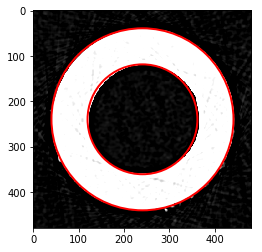

In [42]:
# Create subplot to print reduced image and the marker for the outer and inner diameter
fig, ax = plt.subplots()
circle_inner = plt.Circle((center_innerlumen[0]+tube_padding + wallthickness_x,center_innerlumen[1]+tube_padding + wallthickness_y), d_inner_x/2, color=border_col, fill=False, linewidth=border_wid)
circle_outer = plt.Circle((center[0]+tube_padding,center[1]+tube_padding), d_outer_x/2, color=border_col, fill=False, linewidth=border_wid)
ax.imshow(reduced_img, cmap='gray', interpolation='nearest')
ax.add_artist(circle_inner)
ax.add_artist(circle_outer)
plt.show()
fig.savefig('img_wallthickness.pdf')

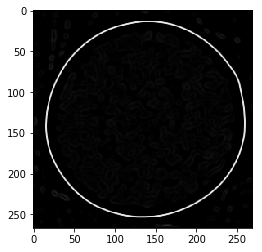

In [32]:
# Radial variation of the radius
img_sobel_offset = filters.sobel(img_offset)
plt.imshow(img_sobel_offset, cmap='gray', interpolation='nearest')
plt.savefig('img_sobel.pdf')

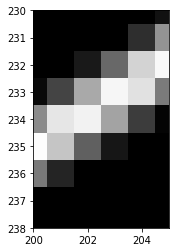

In [33]:
plt.imshow(img_sobel_offset, cmap='gray', interpolation='nearest')
plt.xlim([200,205])
plt.ylim([238,230])
plt.savefig('img_sobel_section.pdf')

In [43]:
edge_indices_offset = np.where(img_sobel_offset)
center_x = (max(edge_indices_offset[0])-min(edge_indices_offset[0]))/2
center_y = (max(edge_indices_offset[1])-min(edge_indices_offset[1]))/2
center = [center_x,center_y]

circle = [edge_indices_offset[0][1],edge_indices_offset[1][1]]
array_radius = [circle,center]
radius = np.diff(array_radius)
print(np.size(edge_indices_offset))
print("Center coord.: ",center_x, center_y)
print("Edge coord.: ",edge_indices_offset)
Radius_Circle = np.sqrt(np.square(radius[0])+np.square(radius[1]))
print("Radius at position: ",Radius_Circle)

77672
Center coord.:  132.0 133.0
Edge coord.:  (array([  1,   1,   1, ..., 265, 265, 265]), array([ 13,  14,  15, ..., 223, 224, 225]))
Radius at position:  [13.03840481]


In [ ]:
r=[]
for w in range(len(edge_indices_offset[0])):
    for h in range(len(edge_indices_offset[1])):
        circle = [edge_indices_offset[0][w],edge_indices_offset[1][h]]
        array_radius = [circle,center]
        radius = np.diff(array_radius)


        #print(center_x, center_y)
        #print(edge_indices_offset)
        Radius_Circle = np.sqrt(np.square(radius[0])+np.square(radius[1]))
        r.append(Radius_Circle)
        #print(Radius_Circle)

print(r)